# Introduction and Setting

##Prepare the dataset

In [1]:
!wget https://raw.githubusercontent.com/toniprada/usa-names-dataset/master/names-dataset.txt


--2024-10-01 08:39:02--  https://raw.githubusercontent.com/toniprada/usa-names-dataset/master/names-dataset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269653 (263K) [text/plain]
Saving to: ‘names-dataset.txt’

names-dataset.txt   100%[===================>] 263.33K  --.-KB/s    in 0.04s   

2024-10-01 08:39:02 (6.93 MB/s) - ‘names-dataset.txt’ saved [269653/269653]



In [2]:
with open('names-dataset.txt', 'r') as file:
    data = file.read()

In [3]:
data = data.split('\n')

In [4]:
print("Length of the data: ",len(data))

data[:10]

Length of the data:  36458


['satara',
 'britiney',
 'rory',
 'charelle',
 'elizeo',
 'dago',
 'poetry',
 'jhase',
 'derika',
 'larsen']

## Import Library

In [5]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

# Bigram Model from scratch

In [6]:
# setup the Vocabulary
vocab = list(sorted(set(''.join(data)))) # all of the token in the data (Character level token)

vocab_size = len(vocab) +1 # (Len of the vocabulary plus one special token '.'

stoi = {ch:i+1 for i,ch in enumerate(vocab)} # a look up table from token to index
stoi['.'] = 0

itos = {i+1:ch for i,ch in enumerate(vocab)} # a look up table from index to token
itos[0] = '.'

for i in range(27):
  print(f'{i}: {itos[i]} {stoi[itos[i]]}')

0: . 0
1: a 1
2: b 2
3: c 3
4: d 4
5: e 5
6: f 6
7: g 7
8: h 8
9: i 9
10: j 10
11: k 11
12: l 12
13: m 13
14: n 14
15: o 15
16: p 16
17: q 17
18: r 18
19: s 19
20: t 20
21: u 21
22: v 22
23: w 23
24: x 24
25: y 25
26: z 26


In [7]:
Count = torch.zeros((vocab_size,vocab_size), dtype=torch.int32) # Get the word count by pair

for w in data:
  pdata = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(pdata, pdata[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    Count[ix1,ix2] += 1

In [8]:
Count.shape

torch.Size([27, 27])

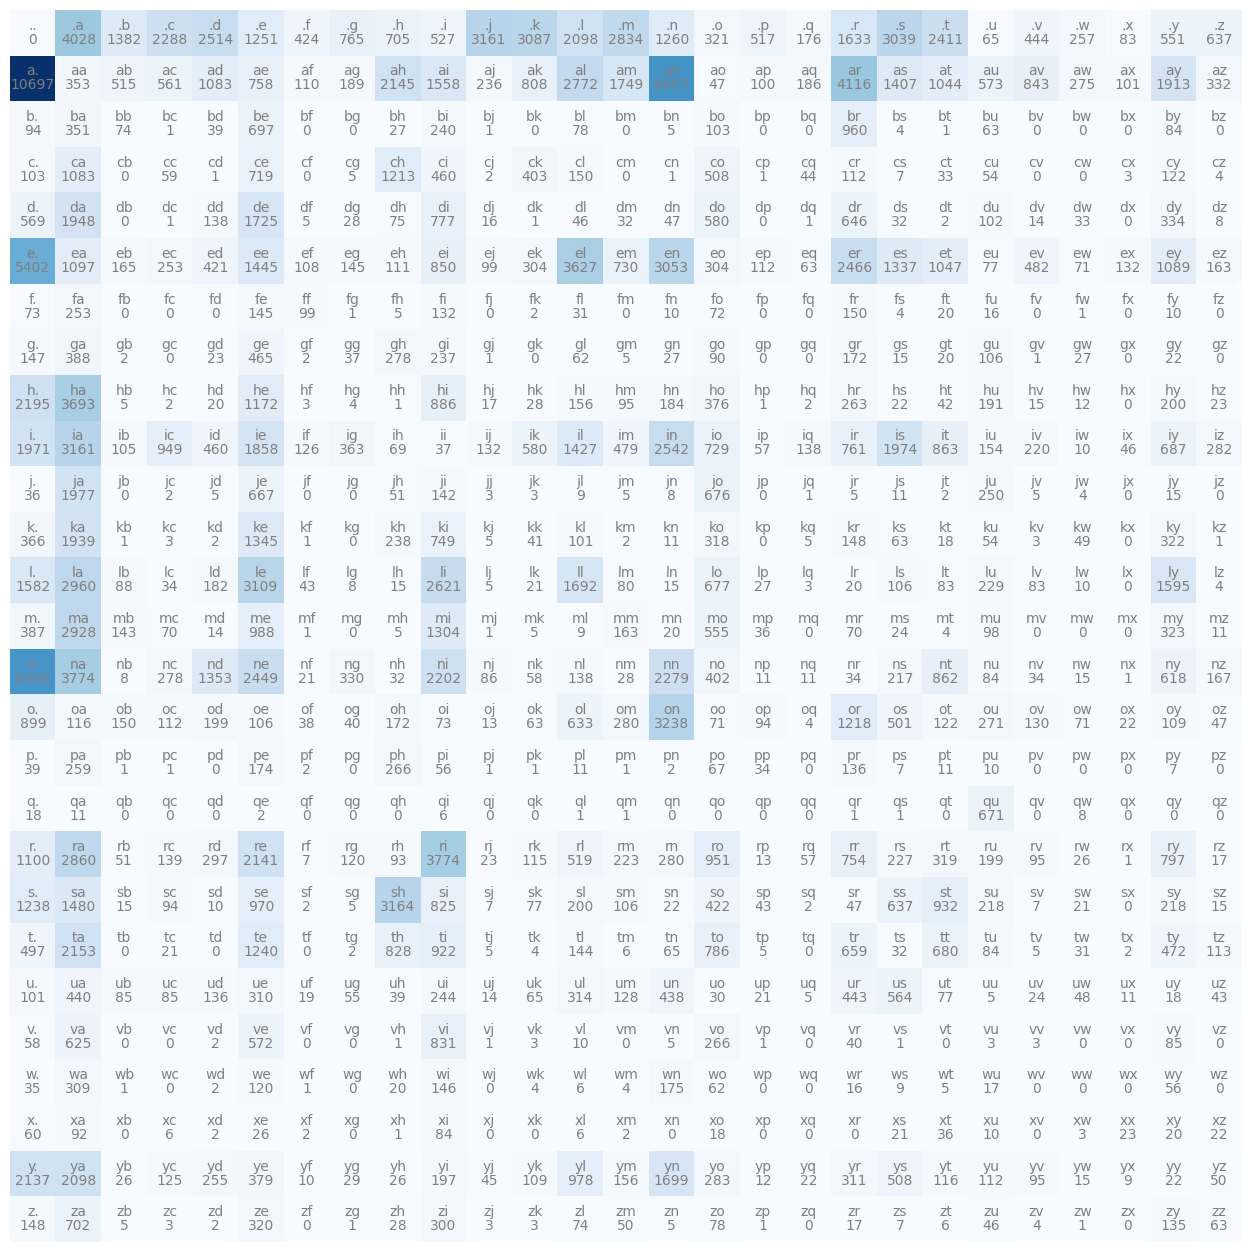

In [9]:
# plot the heat map for word pair
plt.figure(figsize=(16,16))
plt.imshow(Count, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, Count[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [10]:
# Normalize the word count and get the next word probability distribution
P = (Count + 1).float() # Avoid zero probability, the more we increase the flatting the distribution
P /= P.sum(1, keepdim=True)

In [22]:
g = torch.Generator().manual_seed(42)

print("Result generate from Bigram Language Model - Scratch Version:")

for _ in range(10):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

Result generate from Bigram Language Model - Scratch Version:
ya.
syahaviahe.
dleekahmangonya.
tryawe.
chen.
ena.
da.
amiiae.
a.
keles.


In [12]:
# Calculate the log_likelihood of the model

log_likelihood = 0.0
n = 0

for w in data:
  pdata = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(pdata, pdata[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1,ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

nll = -log_likelihood # We want to minimize the loss function so we get the negative (equivalent to maximize the log_likelihood)

print(f'{nll=}')
print(f'{n=}')
print(f'{nll/n}') # normalize the nll

nll=tensor(648994.2500)
n=269654
2.406766653060913


In this part, we have implement the Bigram Language Model by counting the word pair and find the probability distribution for the next characters of each characacter. And also, we have calculate the Negative Log-Likelihood of the model which we will use to compare for the model performance with the model implement by using Neural Network.

# Bigram Model with Neural Network

In [13]:
# Prepare training set

xs, ys = [],[]

for w in data:
  pdata = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(pdata, pdata[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [14]:
xs[:10],ys[:10]

(tensor([ 0, 19,  1, 20,  1, 18,  1,  0,  2, 18]),
 tensor([19,  1, 20,  1, 18,  1,  0,  2, 18,  9]))

In [15]:
# Then, we convert them to one-hot encoded (this will be what we input to the model)

xenc = F.one_hot(xs, num_classes=vocab_size).float()
xenc[:5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
xenc.shape

torch.Size([269654, 27])

In [17]:
# Now, we create a single layer of Neurons
g = torch.Generator().manual_seed(2147483647 + 1)

W = torch.randn((vocab_size, vocab_size), requires_grad= True,  generator= g) # a matrix with initially random weight assigned, the requires_grad = True is for backward pass

In [18]:
# we now want to find the probs[i,next_i] like probs[0,19] because 19 is behind 0 in [ 0, 19,  1, 20,  1, 18,  1,  0,  2, 18]
# then we perform the nll as before and perform Back Propagation for finding the optimal model parameter

for i in range(100):

  logits = xenc @ W # we get the logits, in this case we can consider it as the log-count

  # Then we perform the soft-max on these logits to get the probability distribution
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)

  loss = -probs[torch.arange(len(xs)), ys].log().mean() + 0.01*(W**2).mean() #  regularization part, equivalence to increase Count + 1
  print(f'{i} : loss {loss.item()}')

  W.grad = None # reset the gradient before perform the backward pass

  loss.backward()

  W.data += -50 * W.grad # update the weight

0 : loss 3.676503896713257
1 : loss 3.2850401401519775
2 : loss 3.0823261737823486
3 : loss 2.949946403503418
4 : loss 2.8563904762268066
5 : loss 2.7889063358306885
6 : loss 2.7396657466888428
7 : loss 2.702727794647217
8 : loss 2.6739578247070312
9 : loss 2.6507084369659424
10 : loss 2.631355047225952
11 : loss 2.6148841381073
12 : loss 2.6006393432617188
13 : loss 2.588172674179077
14 : loss 2.577164888381958
15 : loss 2.5673763751983643
16 : loss 2.5586204528808594
17 : loss 2.5507469177246094
18 : loss 2.543632984161377
19 : loss 2.537177324295044
20 : loss 2.53129506111145
21 : loss 2.525916576385498
22 : loss 2.520981550216675
23 : loss 2.5164413452148438
24 : loss 2.5122523307800293
25 : loss 2.508378028869629
26 : loss 2.504788875579834
27 : loss 2.5014562606811523
28 : loss 2.4983572959899902
29 : loss 2.4954700469970703
30 : loss 2.49277663230896
31 : loss 2.490260601043701
32 : loss 2.4879069328308105
33 : loss 2.4857025146484375
34 : loss 2.4836349487304688
35 : loss 2.481

The loss function of this model higher than the one before but the result we get nearly the same (notice that we can increase number of loop for a lower loss).

In [24]:
g = torch.Generator().manual_seed(42)

print("Result generate from Bigram Language Model - Neural Network Version:")

for i in range(10):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to Counts
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

Result generate from Bigram Language Model - Neural Network Version:
ya.
syahaviahe.
dleekahmangwnya.
tryawdachen.
ena.
da.
amiiae.
a.
keles.
ly.


The result we get from the scrath model version:

------

ya.

syahaviahe.


dleekahmangonya.

tryawe.

chen.

ena.

da.

amiiae.

a.

keles.

------

We can see that both Bigram model can capture the patern of the training set (that is, you can see the a. occur a lot in our generated text) and also, the single layer of neurons can capture these patern as well as the simple version model, this provide us a insight view of what exactly the Neural Network model will do.